# cs7324 Lab 6 - Convolutional Neural Networks

#### Chip Henderson - 48996654 

Write something here about the dataset.

There were two I downloaded. One for binary:
https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

And one for classification:
https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/code

## Preparation

In [91]:
# Source modified from in-class notebook
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

print('Tensorflow version:',tf.__version__)



Tensorflow version: 2.12.0


In [92]:
train_folders = r"C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Brain_Tumor_Classification_datset\Training"
test_folders = r"C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Brain_Tumor_Classification_datset\Testing"

# Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
ds_train = tf.keras.utils.image_dataset_from_directory(
    train_folders,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=32, # changed from default 32
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=True
)

ds_test = tf.keras.utils.image_dataset_from_directory(
    test_folders,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=32, # changed from default 32
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


**Revisit this to see how we can make the labels appear as their string versions**

C:\Users\Chip\AppData\Local\Temp\ipykernel_15076\1196846650.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,4,i+1)


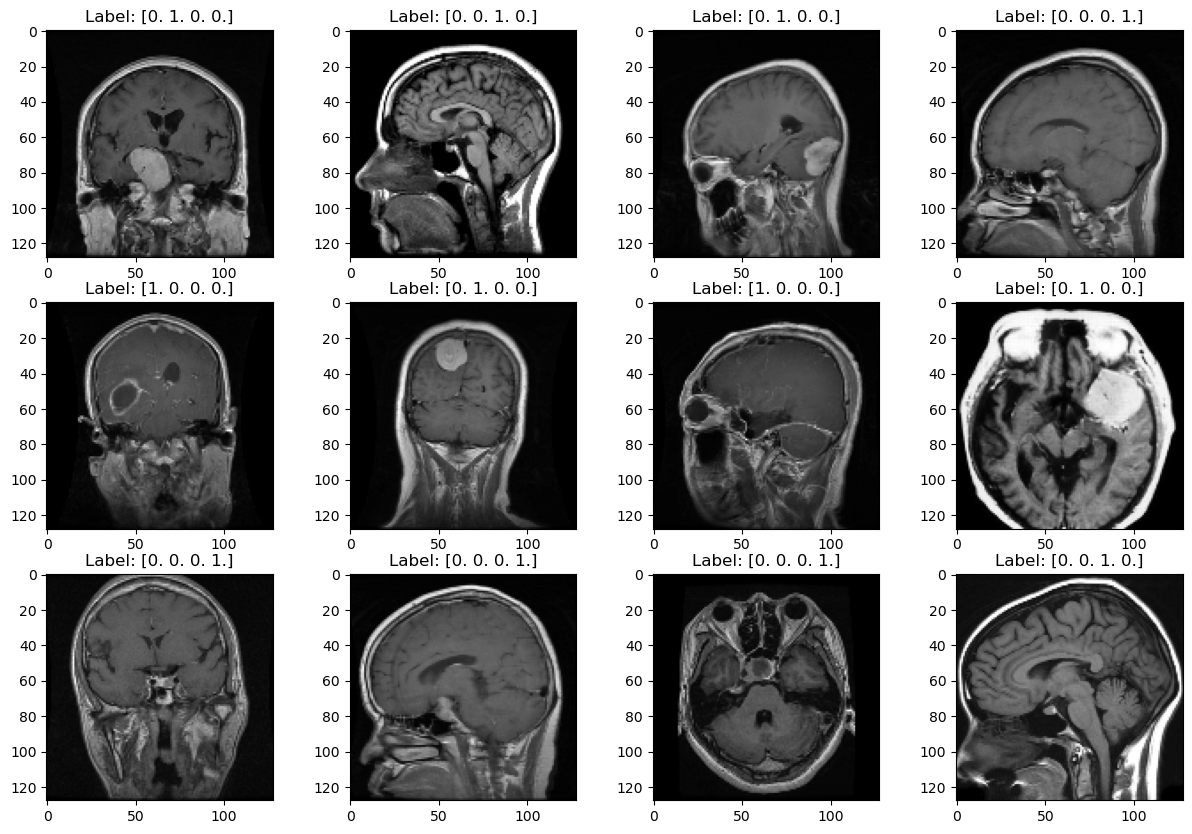

In [11]:
# Source: Code re-use from Lab 2 and 5

import matplotlib.pyplot as plt
class_names = ["Glioma", "Meningioma", "Healthy", "Pituitary"]

plt.subplots(figsize=(15, 10))

# Iterate through the dataset
for i, (images, labels) in enumerate(ds_train.take(12)):
    plt.subplot(3,4,i+1)
    # Display the first image in the batch
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    # label_str = class_names[labels[0].numpy()]
    plt.title(f"Label: {labels[0].numpy()}")
        
plt.show()

Let's check out the balance of samples.
ds_test

### Metrics

I fully expect this to be a very challenging dataset. Just looking at these images you have different orientations which will challenge the ability to reliably detect edges and locations. Where there are positive tumor detection, it is difficult to visually see the difference in what those types of tumors are. Because of this I'm going to focus my metrics on whether or not tumors are detected at all. To do that, I'll focus on trying to measure how many false negatives my model produces.

### Data Split

This dataset came pre-split in training and testing divisions. The total count of each is 2,870 training samples and 394 testing samples. I'd like to see how many of each category exists in my datasets.

The number of Glioma tumors in the training data is 826
The number of Meningioma tumors in the training data is 822
The number of Healthy scans in the training data is 395
The number of Pituitary tumors in the training data is 827

The number of Glioma tumors in the testing data is 100
The number of Meningioma tumors in the testing data is 115
The number of Healthy scans in the testing data is 105
The number of Pituitary tumors in the testing data is 74


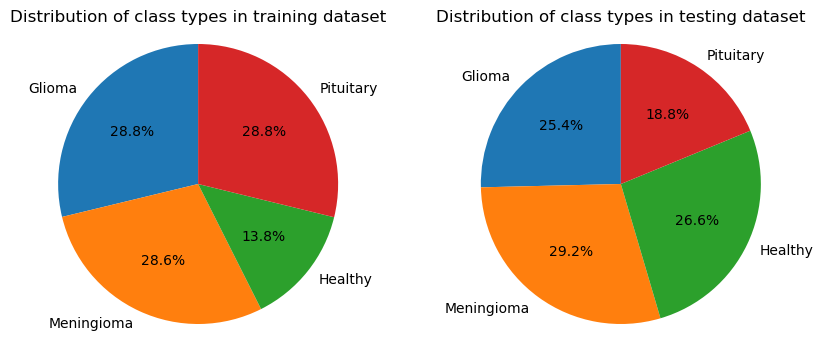

In [90]:
train_cancer_type = []
test_cancer_type = []

batches_train = [label.numpy().astype(int) for (image,label) in ds_train] # get training batches
batches_test = [label.numpy().astype(int) for (image,label) in ds_test] # get testing batches

# Get the individual cancer types from each dataset
for train_batch in batches_train:
    for train_label in train_batch:
        train_cancer_type.append(np.argmax(train_label))

for test_batch in batches_test:
    for test_label in test_batch:
        test_cancer_type.append(np.argmax(test_label))

print(f"The number of Glioma tumors in the training data is {train_cancer_type.count(0)}")
print(f"The number of Meningioma tumors in the training data is {train_cancer_type.count(1)}")
print(f"The number of Healthy scans in the training data is {train_cancer_type.count(2)}")
print(f"The number of Pituitary tumors in the training data is {train_cancer_type.count(3)}\n")

print(f"The number of Glioma tumors in the testing data is {test_cancer_type.count(0)}")
print(f"The number of Meningioma tumors in the testing data is {test_cancer_type.count(1)}")
print(f"The number of Healthy scans in the testing data is {test_cancer_type.count(2)}")
print(f"The number of Pituitary tumors in the testing data is {test_cancer_type.count(3)}")

# Plot the data usig a pie plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
pie_data = [train_cancer_type.count(0), train_cancer_type.count(1), train_cancer_type.count(2), train_cancer_type.count(3)]
plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of class types in training dataset')

plt.subplot(1,2,2)
pie_data = [test_cancer_type.count(0), test_cancer_type.count(1), test_cancer_type.count(2), test_cancer_type.count(3)]
plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of class types in testing dataset')

plt.show()

From the above chart I can see that there are more healthy samples in the testing dataset and fewer pituitary tumors. Also, my test/train split is roughly 88/12.

Not sure if this is an issue yet, but I may want to use kfold or at least explain here why this is ok. These aren't gross differences, they may be acceptable.

## Modeling

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

In [ ]:
%%time

# CREATE A BASELINE MLP WITH THREE LAYERS

# since this is not binary, we should go ahead and one-hot encode the inputs
# y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
# y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
# [(X_train,y_train)] = ds_train.from_tensor_slices

NUM_CLASSES = 4
# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

mlp.fit(ds_train, 
        batch_size=32, epochs=10, # was 150, tuned down to verify it works
        shuffle=True, verbose=1)



Epoch 1/10


90/90 [==============================] - 4s 27ms/step - loss: 0.3568 - accuracy: 0.2864
Epoch 2/10
90/90 [==============================] - 2s 25ms/step - loss: 0.3559 - accuracy: 0.2882
Epoch 3/10
90/90 [==============================] - 2s 25ms/step - loss: 0.3559 - accuracy: 0.2882
Epoch 4/10
90/90 [==============================] - 2s 26ms/step - loss: 0.3559 - accuracy: 0.2882
Epoch 5/10
90/90 [==============================] - 2s 25ms/step - loss: 0.3559 - accuracy: 0.2882
Epoch 6/10
90/90 [==============================] - 2s 25ms/step - loss: 0.3559 - accuracy: 0.2882
Epoch 7/10
90/90 [==============================] - 3s 26ms/step - loss: 0.3559 - accuracy: 0.2882
Epoch 8/10
90/90 [==============================] - 3s 26ms/step - loss: 0.3559 - accuracy: 0.2882
Epoch 9/10
90/90 [==============================] - 2s 26ms/step - loss: 0.3559 - accuracy: 0.2882
Epoch 10/10
90/90 [==============================] - 2s 25ms/step - loss: 0.3559 - accuracy: 0.2882
CPU times: total: 57

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      80        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 activation_5 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 flatten_4 (Flatten)         (None, 262144)            0         
                                                                 
 dense_10 (Dense)            (None, 4)                 1048580   
                                                                 
 activation_6 (Activation)   (None, 4)                 0         
                                                      

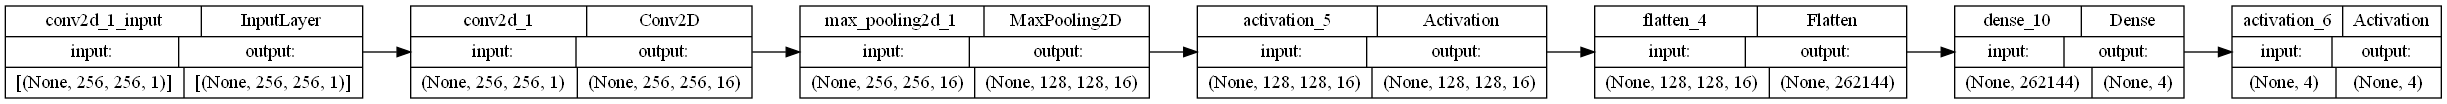

In [ ]:
%%time

# CREATE A CNN WITH ONLY ONE CONVOLUTIONAL LAYER AND ONE OUTPUT LAYER

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', 
                input_shape=(256,256,1),
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

print(cnn.summary())

plot_model(
    cnn, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
%%time 

# the shape of input (batch x h x w x channels)
# print(X_train.shape)

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

cnn.fit(ds_train, 
        batch_size=32, epochs=10, 
        shuffle=True, verbose=1)

Epoch 1/10


90/90 [==============================] - 17s 174ms/step - loss: 0.3567 - accuracy: 0.2861
Epoch 2/10
90/90 [==============================] - 16s 171ms/step - loss: 0.3561 - accuracy: 0.2878
Epoch 3/10
90/90 [==============================] - 16s 172ms/step - loss: 0.3561 - accuracy: 0.2878
Epoch 4/10
90/90 [==============================] - 16s 173ms/step - loss: 0.3561 - accuracy: 0.2878
Epoch 5/10
90/90 [==============================] - 16s 181ms/step - loss: 0.3561 - accuracy: 0.2878
Epoch 6/10
90/90 [==============================] - 17s 186ms/step - loss: 0.3561 - accuracy: 0.2878
Epoch 7/10
90/90 [==============================] - 21s 232ms/step - loss: 0.3561 - accuracy: 0.2878
Epoch 8/10
90/90 [==============================] - 19s 207ms/step - loss: 0.3561 - accuracy: 0.2878
Epoch 9/10
90/90 [==============================] - 19s 211ms/step - loss: 0.3561 - accuracy: 0.2878
Epoch 10/10
90/90 [==============================] - 18s 202ms/step - loss: 0.3561 - accuracy: 0.2878
